# Churn Prediction Project

Questions to answer:
    - Which clients are leaving ?
    - Why are clients leaving ?
    - Which characterctics best help determine if a client is about to churn ? 

**Import all necessary libraries**

In [2059]:
# data manipulation
import pandas as pd
import numpy as np

# data visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

# utils
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_curve
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE


# Managing Warnings 
import warnings
warnings.filterwarnings('ignore')

## Get the data

In [2060]:
# load our customer churn data into the environment using pandas library
df = pd.read_csv('Telco-Customer-Churn.csv')

In [2061]:
# check the data shape ( rows , columns )
print(df.shape)

(7043, 21)


In [2062]:
# Peep the first 5 data examples 
df.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Exploring our data

#### Understanding our columns 
- customerID - uniquely identifies a customer
- gender (nominal)  - male or female 
- SeniorCitizen (nominal) - senior citizen or not
- Partner (nominal) - has a significant other or not
- Dependents (nominal) - has dependents or note
- tenure (interval) - the number of months the customer has been with the company
- PhoneService (nominal) - has a phone service or not
- MultipleLines (nominal) - has multiple lines or not
- InternetService (nominal) - the customers internet service provider 
- OnlineSecurity (nominal) -  has online security or not
- OnlineBackup (nominal) - has online backup or not
- DeviceProtection (nominal) - device protection or not
- TechSupport (nominal) - has techsupport or not
- StreamingTV (nominal) - has streaming tv or not
- Contract (nominal) - contract term of a customer (month-to-month, year, two years)
- PaperlessBilling (nominal) - paperless billing or not
- PaymentMethod (nominal) - prefered payment method
- MonthlyCharges (ratio)  - amount charged to the customer monthly
- TotalCharges (ratio) - total charged to the customer since inception
- Churn (nominal) - churned or not (target variable)

In [2063]:
# check all the column datatypes
print(df.dtypes)

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object


In [2064]:
# returns the number of missing values as a percentage
def missing_percentage(data):
    percentage = round((data.isna().sum() / len(data)) * 100, 2)
    return percentage

In [2065]:
# check all the columns for any missing data
missing_percentage(df)

customerID          0.0
gender              0.0
SeniorCitizen       0.0
Partner             0.0
Dependents          0.0
tenure              0.0
PhoneService        0.0
MultipleLines       0.0
InternetService     0.0
OnlineSecurity      0.0
OnlineBackup        0.0
DeviceProtection    0.0
TechSupport         0.0
StreamingTV         0.0
StreamingMovies     0.0
Contract            0.0
PaperlessBilling    0.0
PaymentMethod       0.0
MonthlyCharges      0.0
TotalCharges        0.0
Churn               0.0
dtype: float64

In [2066]:
# statistic information on numerical columns
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


## Visualizing our data

Lets visualize each of our features individually

In [2067]:
# create a new dataframe that holds our features as we analyse them
df_bin = pd.DataFrame() 

##### Special functions

In [2068]:
# returns a breakdown of percentage per value item
def value_percentage(col):
    # compute the percentage
    percentage = col.value_counts(normalize=True).reset_index()
    percentage.columns = ['Value', 'Percentage']
    percentage['Percentage'] = round(percentage['Percentage'] * 100, 2)
    
    # compute the count
    total = col.value_counts().reset_index()
    total.columns = ['Value', 'TotalCount']
    
    final = percentage.merge(total, on='Value')
    
    return final

In [2069]:
# convert categorical yes/no into 0/1
def yes_no(val):
    return 0 if val.lower() == 'no' else 1

### Feature: Churn 
This is the target variable we would like the model to predict.

Key: 0 = no churn; 1 = churn

In [2070]:
# convert caterogical values into numerical values
df_bin['churn'] = df['Churn'].apply(yes_no)

   Value  Percentage  TotalCount
0      0       73.46        5174
1      1       26.54        1869


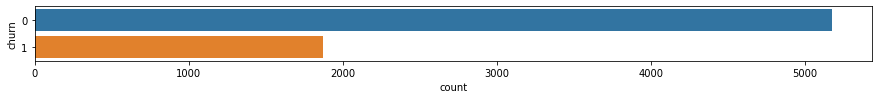

In [2071]:
# how many customer churned ?
fig = plt.figure(figsize=(15, 1))
sns.countplot(y='churn', data=df_bin)
print(value_percentage(df_bin['churn']))

### Feature: gender
The clients gender representation in our data.

In [2072]:
df_bin['gender'] = df['gender']

    Value  Percentage  TotalCount
0    Male       50.48        3555
1  Female       49.52        3488


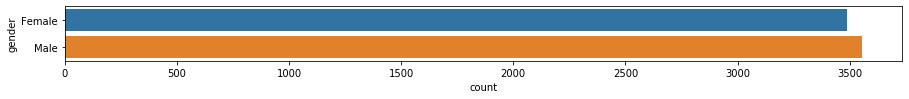

In [2073]:
# what is the gender representation in our data ?
plt.figure(figsize=(15, 1))
sns.countplot(y='gender', data=df_bin)
print(value_percentage(df_bin['gender']))

### Feature: Senior citizen
Distribution of Senior citizens compared to non senior citizens

In [2074]:
# whats the distribution of senior citizens in our data ? 
df_bin['seniorcitizen'] = df['SeniorCitizen']

   Value  Percentage  TotalCount
0      0       83.79        5901
1      1       16.21        1142


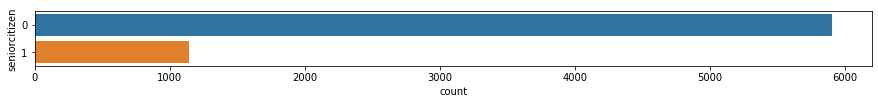

In [2075]:
plt.figure(figsize=(15, 1))
sns.countplot(y='seniorcitizen', data=df_bin)
print(value_percentage(df_bin['seniorcitizen']))
plt.show()

### Feature: Partner
Distribution of clients with and without Partners (Spouses).

In [2076]:
df_bin['partner'] = df['Partner'].apply(yes_no)

   Value  Percentage  TotalCount
0      0        51.7        3641
1      1        48.3        3402


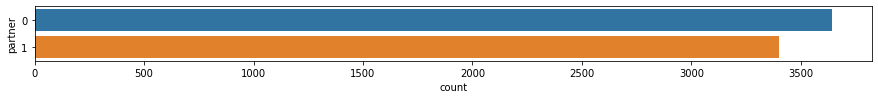

In [2077]:
fig = plt.figure(figsize=(15, 1))
sns.countplot(y='partner', data=df_bin)
print(value_percentage(df_bin['partner']))

### Feature: Dependents
The distribution of clients with dependents and those without dependents

In [2078]:
df_bin['dependents'] = df['Dependents'].apply(yes_no)

   Value  Percentage  TotalCount
0      0       70.04        4933
1      1       29.96        2110


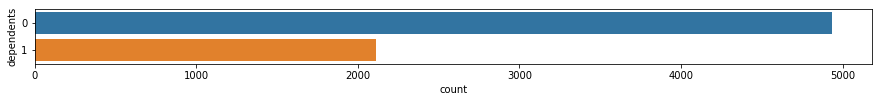

In [2079]:
fig = plt.figure(figsize=(15, 1))
sns.countplot(y='dependents', data=df_bin)
print(value_percentage(df_bin['dependents']))
plt.show()

### Feature: Tenure
Tenure - indication (in months) of how long clients have been with the company

In [2080]:
df_bin['tenure'] = df['tenure']

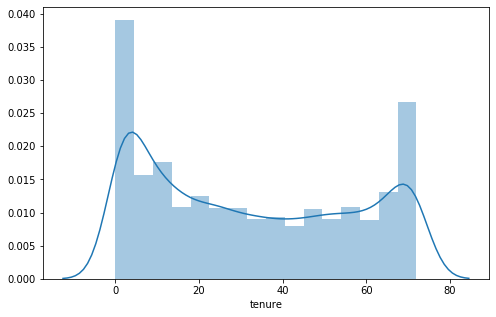

In [2081]:
# how long has our customers been with the company ? 
fig = plt.figure(figsize=(8,5))
sns.distplot(df_bin['tenure'])
plt.show()

### Feature: Phone Service

In [2082]:
df_bin['phoneservice'] = df['PhoneService'].apply(yes_no)

   Value  Percentage  TotalCount
0      1       90.32        6361
1      0        9.68         682


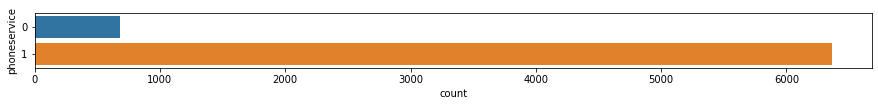

In [2083]:
fig = plt.figure(figsize=(15, 1))
sns.countplot(y='phoneservice', data=df_bin)
print(value_percentage(df_bin['phoneservice']))
plt.show()

### Feature: MultipleLines
Clients with multiple phone lines.

In [2084]:
df_bin['multiplelines'] = df['MultipleLines']

              Value  Percentage  TotalCount
0                No       48.13        3390
1               Yes       42.18        2971
2  No phone service        9.68         682


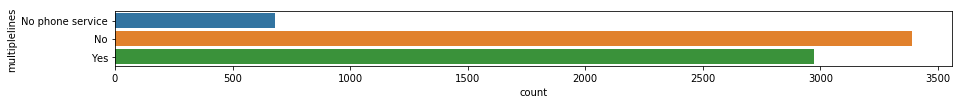

In [2085]:
# for customers with phone services how many have multiple phone lines ? 
fig = plt.figure(figsize=(15, 1))
sns.countplot(y='multiplelines', data=df_bin)
print(value_percentage(df_bin['multiplelines']))
plt.show()

### Feature: Internet Service

In [2086]:
df_bin['internetservice'] = df['InternetService']

         Value  Percentage  TotalCount
0  Fiber optic       43.96        3096
1          DSL       34.37        2421
2           No       21.67        1526


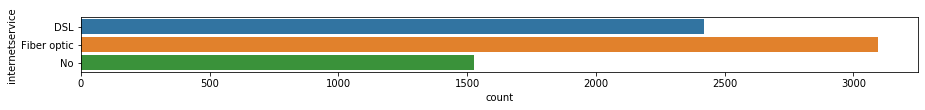

In [2087]:
fig = plt.figure(figsize=(15, 1))
sns.countplot(y='internetservice', data=df_bin)
print(value_percentage(df_bin['internetservice']))
plt.show()

### Feature: Online Security
Clients with online security enabled.

In [2088]:
df_bin['onlinesecurity'] = df['OnlineSecurity']

                 Value  Percentage  TotalCount
0                   No       49.67        3498
1                  Yes       28.67        2019
2  No internet service       21.67        1526


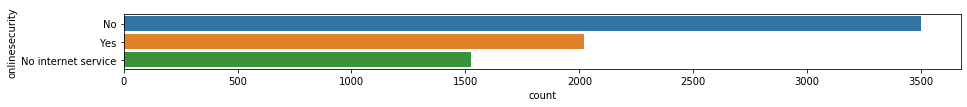

In [2089]:
# for customers with internet service how many have online security enabled ? 
fig = plt.figure(figsize=(15, 1))
sns.countplot(y='onlinesecurity', data=df_bin)
print(value_percentage(df_bin['onlinesecurity']))
plt.show()

### Feature: Online Backup

In [2090]:
df_bin['onlinebackup'] = df['OnlineBackup']

                 Value  Percentage  TotalCount
0                   No       43.84        3088
1                  Yes       34.49        2429
2  No internet service       21.67        1526


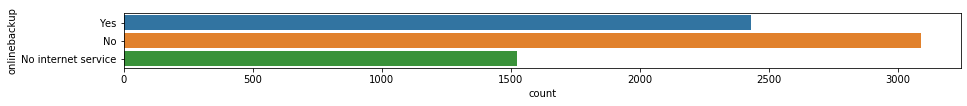

In [2091]:
# for customers with internet services how many have online backup ? 
fig = plt.figure(figsize=(15, 1))
sns.countplot(y='onlinebackup', data=df_bin)
print(value_percentage(df_bin['onlinebackup']))
plt.show()

### Feature: Device Protection

In [2092]:
df_bin['deviceprotection'] = df['DeviceProtection']

                 Value  Percentage  TotalCount
0                   No       43.94        3095
1                  Yes       34.39        2422
2  No internet service       21.67        1526


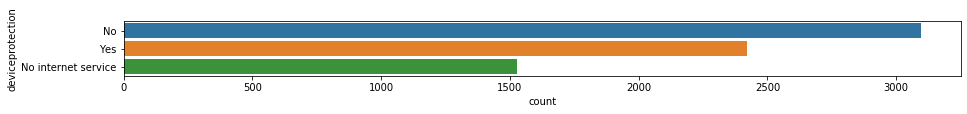

In [2093]:
# for customers with internet services how many have device protection ?
fig = plt.figure(figsize=(15, 1))
sns.countplot(y='deviceprotection', data=df_bin)
print(value_percentage(df_bin['deviceprotection']))
plt.show()

### Feature: Tech Support

In [2094]:
df_bin['techsupport'] = df['TechSupport']

                 Value  Percentage  TotalCount
0                   No       49.31        3473
1                  Yes       29.02        2044
2  No internet service       21.67        1526


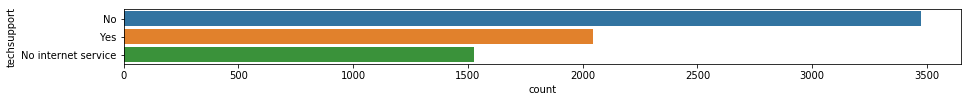

In [2095]:
# for customers with internet services how many have tech support ?
fig = plt.figure(figsize=(15, 1))
sns.countplot(y='techsupport', data=df_bin)
print(value_percentage(df_bin['techsupport']))
plt.show()

### Feature: StreamingTV

In [2096]:
df_bin['streamingtv'] = df['StreamingTV']

                 Value  Percentage  TotalCount
0                   No       39.90        2810
1                  Yes       38.44        2707
2  No internet service       21.67        1526


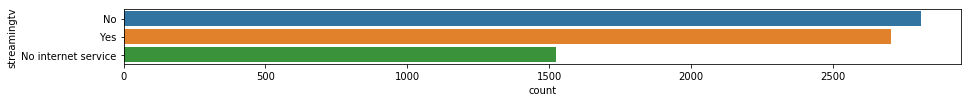

In [2097]:
fig = plt.figure(figsize=(15, 1))
sns.countplot(y='streamingtv', data=df_bin)
print(value_percentage(df_bin['streamingtv']))
plt.show()

### Feature: StreamingMovies

In [2098]:
df_bin['streamingmovies'] = df['StreamingMovies']

                 Value  Percentage  TotalCount
0                   No       39.90        2810
1                  Yes       38.44        2707
2  No internet service       21.67        1526


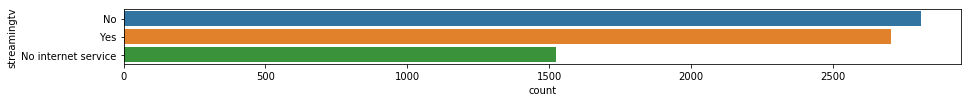

In [2099]:
fig = plt.figure(figsize=(15, 1))
sns.countplot(y='streamingtv', data=df_bin)
print(value_percentage(df_bin['streamingtv']))
plt.show()

### Feature: Contract 
The type of contact the client has with the company.

In [2100]:
df_bin['contract'] = df['Contract']

            Value  Percentage  TotalCount
0  Month-to-month       55.02        3875
1        Two year       24.07        1695
2        One year       20.91        1473


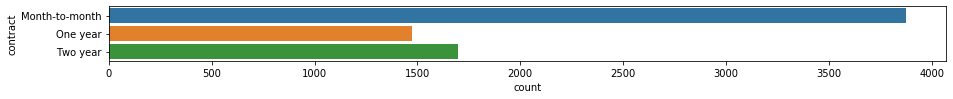

In [2101]:
# what contract types are clients subscribed to ? 
fig = plt.figure(figsize=(15, 1))
sns.countplot(y='contract', data=df_bin)
print(value_percentage(df_bin['contract']))
plt.show()

### Feature: Paperless Billing

In [2102]:
df_bin['paperlessbilling'] = df['PaperlessBilling'].apply(yes_no)

   Value  Percentage  TotalCount
0      1       59.22        4171
1      0       40.78        2872


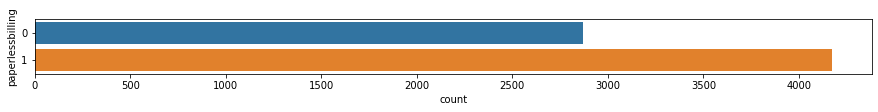

In [2103]:
# how many clients subscribe to paperless billing ?
fig = plt.figure(figsize=(15, 1))
sns.countplot(y='paperlessbilling', data=df_bin)
print(value_percentage(df_bin['paperlessbilling']))
plt.show()

### Feature: Payment Method

In [2104]:
df_bin['paymentmethod'] = df['PaymentMethod']

                       Value  Percentage  TotalCount
0           Electronic check       33.58        2365
1               Mailed check       22.89        1612
2  Bank transfer (automatic)       21.92        1544
3    Credit card (automatic)       21.61        1522


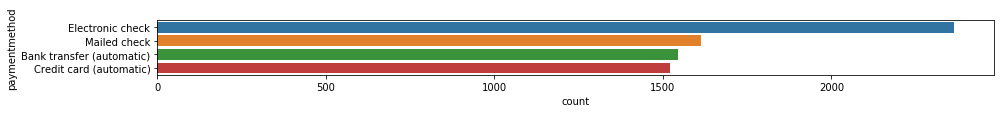

In [2105]:
# how are clients settling their bill ?
fig = plt.figure(figsize=(15, 1))
sns.countplot(y='paymentmethod', data=df_bin)
print(value_percentage(df_bin['paymentmethod']))
plt.show()

### Feature: MonthlyCharges
Client monthly charge.

In [2106]:
df_bin['monthlycharges'] = df['MonthlyCharges']

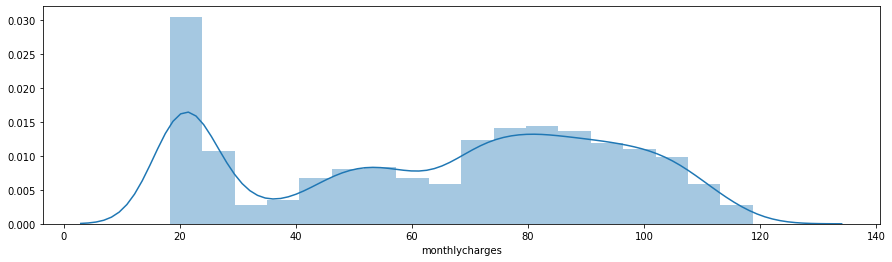

In [2107]:
# how much are client being charged on a monthly ?
fig = plt.figure(figsize=(15, 4))
sns.distplot(df_bin['monthlycharges'])
plt.show()

### Feature: TotalCharges

In [2108]:
# fill empty values with zero
df_bin['totalcharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce').fillna(0)

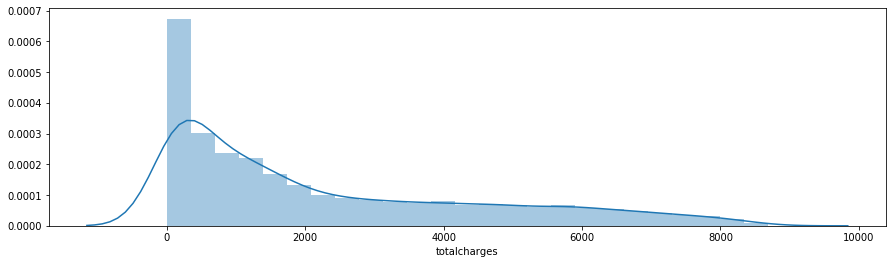

In [2109]:
# how much have client been charged in total ?
fig = plt.figure(figsize=(15, 4))
sns.distplot(df_bin['totalcharges'])
plt.show()

## Bivariante analysis

### Features: Churn + Tenure

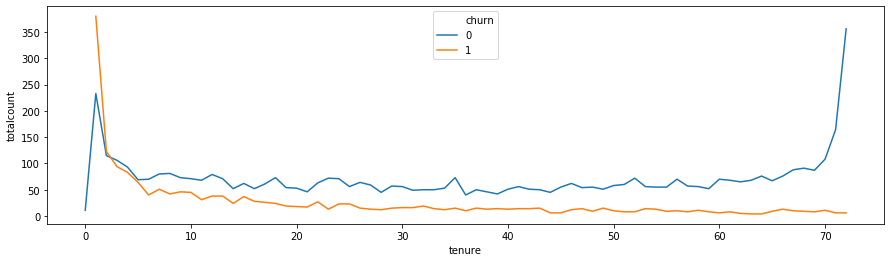

In [2110]:
# at which tenure stage are clients churning ? 
df_tenure = df_bin.groupby(['churn', 'tenure']).agg({'tenure': 'count'}).rename(columns={'tenure': 'totalcount'}).reset_index()
fig = plt.figure(figsize=(15, 4))
sns.lineplot(y='totalcount', x='tenure', hue='churn', data=df_tenure)
plt.show()

### Features: Churn + MonthlyCharges

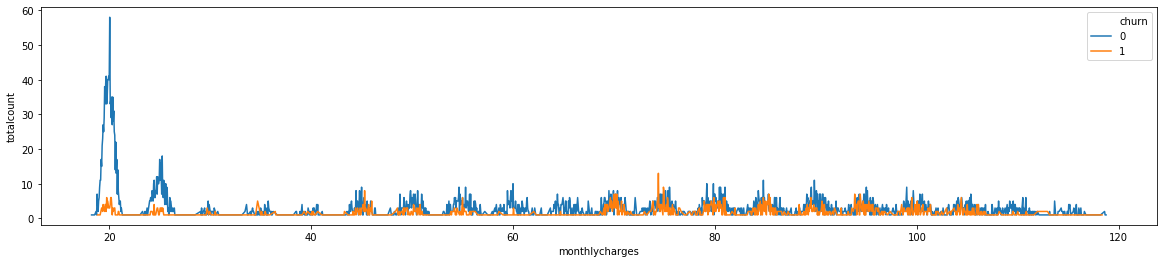

In [2111]:
df_charges = df_bin.groupby(['churn', 'monthlycharges']).agg({'monthlycharges': 'count'}).rename(columns={'monthlycharges': 'totalcount'}).reset_index()
fig = plt.figure(figsize=(20, 4))
sns.lineplot(y='totalcount', x='monthlycharges', hue='churn', data=df_charges)
plt.show()

### Features: Churn + TotalCharges

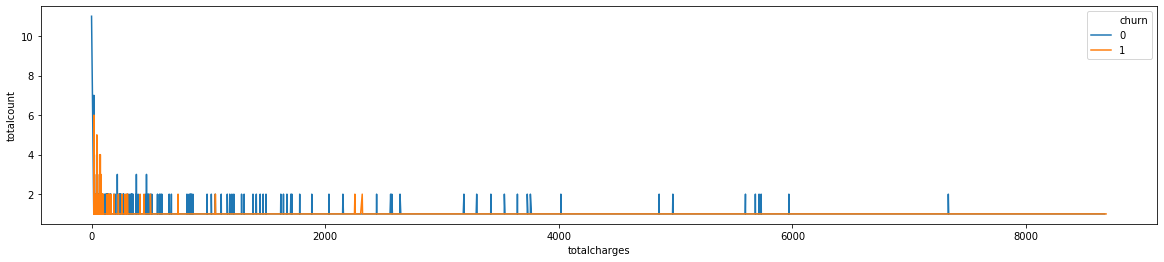

In [2112]:
### Features: Churn + MonthlyCharges
df_charges = df_bin.groupby(['churn', 'totalcharges']).agg({'totalcharges': 'count'}).rename(columns={'totalcharges': 'totalcount'}).reset_index()
fig = plt.figure(figsize=(20, 4))
sns.lineplot(y='totalcount', x='totalcharges', hue='churn', data=df_charges)
plt.show()

## Feature correlation 

In [2113]:
df_corr = df_bin.corr()

(9.0, 0.0)

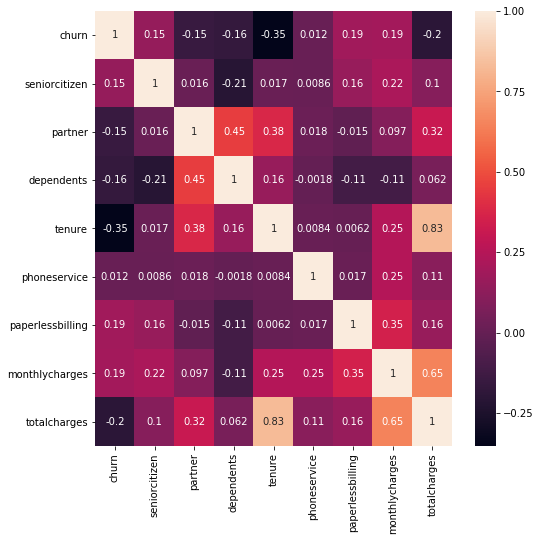

In [2114]:
fig = plt.figure(figsize=(8, 8))
ax = sns.heatmap(df_corr, annot=True) #notation: "annot" not "annote"
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

## Prepare the data

In [2115]:
# look at the data
df_bin.head()

,churn,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges
0,0,Female,0,1,0,1,0,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,1,Electronic check,29.85,29.85
1,0,Male,0,0,0,34,1,No,DSL,Yes,No,Yes,No,No,No,One year,0,Mailed check,56.95,1889.50
2,1,Male,0,0,0,2,1,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,1,Mailed check,53.85,108.15
3,0,Male,0,0,0,45,0,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,0,Bank transfer (automatic),42.30,1840.75
4,1,Female,0,0,0,2,1,No,Fiber optic,No,No,No,No,No,No,Month-to-month,1,Electronic check,70.70,151.65


### Feature encoding

In [2116]:
# get all numeric columns 
df_obj = df_bin.select_dtypes(include=['object']).columns.to_list()

In [2117]:
# create dummy variables for our categorical features
df_bin = pd.get_dummies(df_bin, columns=df_obj, drop_first=True)

### Split our data

In [2118]:
# seperate our variables from our target
y = df_bin['churn']
X = df_bin.drop(['churn'], axis=1)

In [2119]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [2120]:
print("Training shape: ", X_train.shape)
print("Testing shape: ", X_test.shape)

Training shape:  (5634, 30)
Testing shape:  (1409, 30)


### Handling imbalanced data
Always performing sampling after splitting the data into train/testing samples. 

In [2121]:
sm = SMOTE(random_state=27, ratio=1.0)

In [2122]:
X_train, y_train = sm.fit_sample(X_train, y_train)

### Feature scaling

In [2123]:
# create an instance of our scaler and scale our features dataset
scaler = MinMaxScaler() # try our RobustScaler also
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

## Fitting our algorithm

In [2124]:
def fit_ml_algo(algorithm, X_train, y_train, X_test, y_test):
    # first setup the algorithm
    model = algorithm.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # measure precision and recall
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    # predict the probability
    y_prob = model.predict_proba(X_test)[:,1]
    
    # roc curve
    fpr, tpr, threshold = roc_curve(y_test, y_prob)
    
    if isinstance(algorithm, LogisticRegression):
        importances = model.coef_[0]
    else:
        importances = model.feature_importances_
    
    return accuracy, precision, recall, conf_matrix, fpr, tpr, importances

In [2125]:
# function for plotting the ROC Curve
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

#### Logistic Regression algorithm

In [2126]:
accuracy, precision, recall, conf_matrix, fpr, tpr, importance = fit_ml_algo(LogisticRegression(), X_train, y_train, X_test, y_test)
print('Accuracy: ', round(accuracy * 100, 2))
print('Precision: ', round(precision * 100, 2))
print('Recall: ', round(recall * 100, 2))

Accuracy:  75.51
Precision:  52.37
Recall:  82.84


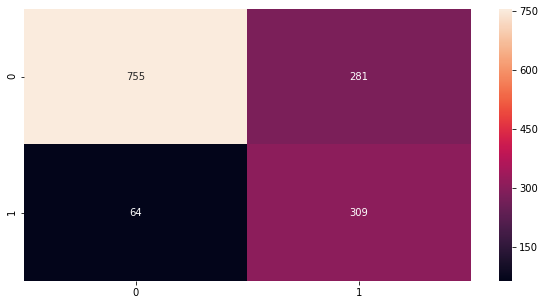

In [2127]:
fig = plt.figure(figsize=(10, 5))
ax = sns.heatmap(conf_matrix, annot=True, fmt='g') #notation: "annot" not "annote"
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

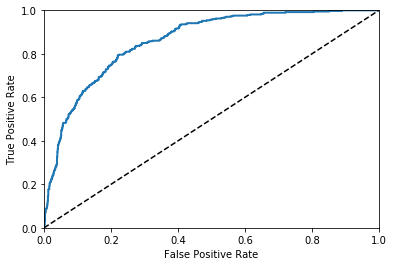

In [2128]:
# plot our roc curve
plot_roc_curve(fpr, tpr)

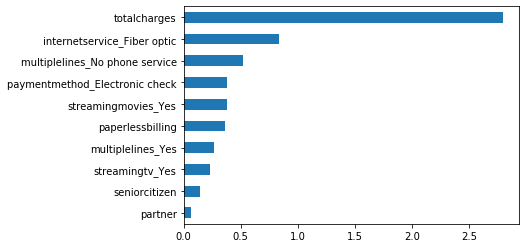

In [2129]:
weights = pd.Series(importance,
                 index=X.columns.values)
weights.sort_values()[-10:].plot(kind = 'barh')

#### Random Forest classifier

In [2130]:
accuracy, precision, recall, conf_matrix, fpr, tpr, importance = fit_ml_algo(RandomForestClassifier(class_weight="balanced"), X_train, y_train, X_test, y_test)
print('Accuracy: ', round(accuracy * 100, 2))
print('Precision: ', round(precision * 100, 2))
print('Recall: ', round(recall * 100, 2))

Accuracy:  78.92
Precision:  63.77
Recall:  47.18


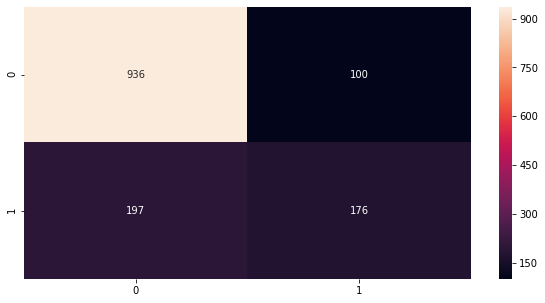

In [2131]:
fig = plt.figure(figsize=(10, 5))
ax = sns.heatmap(conf_matrix, annot=True, fmt='g') #notation: "annot" not "annote"
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

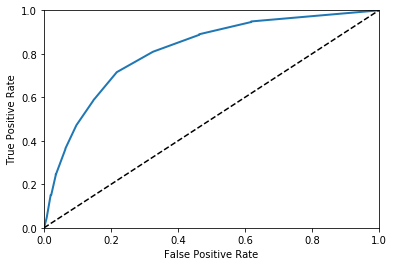

In [2132]:
# plot our roc curve
plot_roc_curve(fpr, tpr)

#### AdaBoost Classifier

In [2133]:
accuracy, precision, recall, conf_matrix, fpr, tpr, importance  = fit_ml_algo(AdaBoostClassifier(), X_train, y_train, X_test, y_test)
print('Accuracy: ', round(accuracy * 100, 2))
print('Precision: ', round(precision * 100, 2))
print('Recall: ', round(recall * 100, 2))

Accuracy:  80.13
Precision:  61.15
Recall:  68.36


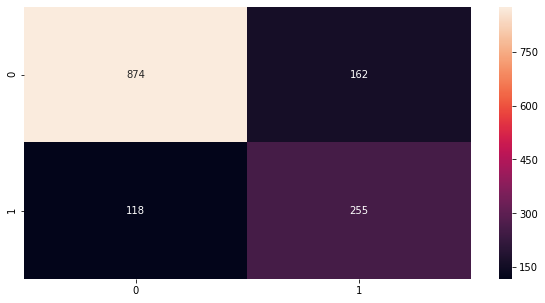

In [2134]:
fig = plt.figure(figsize=(10, 5))
ax = sns.heatmap(conf_matrix, annot=True, fmt='g') #notation: "annot" not "annote"
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

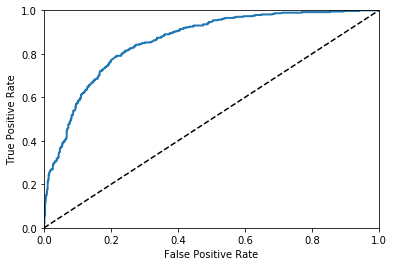

In [2135]:
# plot our roc curve
plot_roc_curve(fpr, tpr)

#### GradientBoostingClassifier

In [2136]:
accuracy, precision, recall, conf_matrix, fpr, tpr, importance  = fit_ml_algo(GradientBoostingClassifier(), X_train, y_train, X_test, y_test)
print('Accuracy: ', round(accuracy * 100, 2))
print('Precision: ', round(precision * 100, 2))
print('Recall: ', round(recall * 100, 2))

Accuracy:  80.27
Precision:  62.87
Recall:  62.2


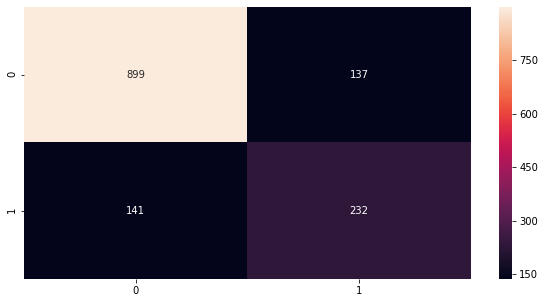

In [2137]:
fig = plt.figure(figsize=(10, 5))
ax = sns.heatmap(conf_matrix, annot=True, fmt='g') #notation: "annot" not "annote"
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

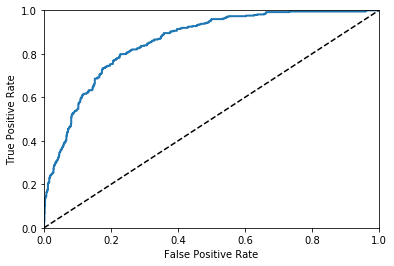

In [2138]:
# plot our roc curve
plot_roc_curve(fpr, tpr)